Initial approach I thought about to this problem, is that a shop assistant could make a photo of a shelf when it's arranged in a correct way, having his mobile phone to color the items based on a SKU. When in need to rearrange or simply check, assistant could take another photo and compare the outcome.

In order to do that, we need a classifier which will recognize the bottles and will be able to classify each of them.

I see here application of general approach for object recognition, which is training a convolution neural network on images of different bottles and then run a detection throughout the final image to detect the images.

Looking at the dataset of images of bottles, I can think of several things:
* images of the same bottles are of different perspective/part/angle so having convolutional network will allow it to learn patterns that it can look for when scanning parts of images in order to look for the bottles
* images of the dataset can be aligned in some ways to achieve better results
* images themselves can be grayscaled as in looking for patterns in logos, bottle shapes etc doesn't neccesarily required storing the color information
* color information can be used as overall information, using for example histograms of colors
* techniques such as gradients combined with histogram data can improve the data with storing patterns of shapes+colors
* standard image processing as blurring, thresholding, transforming can give better results as only significant information will be preserved
* combining all of the features requires normalization, as histogram data and image pixel data will vary
* if we need to make this model run very fast, we should also normalize the data so it is based of integers, not floats, as this speeds up computation

About the network itself, convolution networks has proven themselves to be efficient in such cases, so I probably wouldn't go for another approach at the first place. I can't provide exact network architecture that would work well, but trying to work something out by myself quickly, I started with LeNet architecture, just because I'm most familiar with that. Looks like it has very good result, because without much work I got very high results.

Something worth investigating, having more time to complete the task, would be application of CNN designed especially for finding objects in images, like YOLO or SSD. But having a model trained to recognize the objects themselves, we could simply run a detection through specified boxes throughout the entire image, and check their contents, if they contain the bottles. Though this would be massively computationally heavy as whole image would be scanned and have a classification applied, assuming that the image is mostly containing the shelf instead, it would assume that our whole image is a strong area of interest, so that wouldn't make a sense to loose time to look for the areas of interest in the image.

I don't have an idea for a good approach to detect and show the bottles which are in or not in a good place. Having information about the right placement could be compared with the data from a camera, looking at the order of products, assuming that first recognized is first in a row, and just some sort of manually compared in an app.

Below is some very-quickly-not-nicely-done code for that just training a model recognizing the bottles. Unfortunately I focused on a network and everything around, but if that's ok, I would improve it with more serious data preparation as stated above and try out different learning approached.

In [1]:
import numpy as np
import tensorflow as tf
import glob
import cv2
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

/home/kzon/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#load data and get label it accordingly
data_source = './data/Recognition/*'
data_source_files = glob.glob(data_source)

data = []
labels = []
non_bottles = []

LIMIT = 500

for i, dir_name in enumerate(data_source_files):
    if dir_name in ['./data/Recognition/background', './data/Recognition/background2']:
        non_bottles.append(i)
    
    print("Extracting data from {0}".format(dir_name))
    img_files = glob.iglob("{0}/*".format(dir_name))
    
    for j, img_name in enumerate(img_files):
        if j > LIMIT:
            break
        image = cv2.imread(img_name)
        if image is None:
            print("Something wrong with {0}".format(img_name))
            continue
        data.append(image)
        labels.append(i)
        

Extracting data from ./data/Recognition/global_village_oliv
Extracting data from ./data/Recognition/blago_podsolnech_classic
Extracting data from ./data/Recognition/mechta_hozyaiki
Extracting data from ./data/Recognition/altero
Extracting data from ./data/Recognition/aromat_gizni_podsolnech
Extracting data from ./data/Recognition/oleina_1l_oliv
Extracting data from ./data/Recognition/ricco
Extracting data from ./data/Recognition/global_village_classic
Something wrong with ./data/Recognition/global_village_classic/3971212IMG_2921_000224.jpg
Extracting data from ./data/Recognition/zlato
Extracting data from ./data/Recognition/itlv_grape
Something wrong with ./data/Recognition/itlv_grape/2924_4861198IMG_2924_000043.jpg
Something wrong with ./data/Recognition/itlv_grape/5231017IMG_2921_000065.jpg
Something wrong with ./data/Recognition/itlv_grape/2930_3111212IMG_2930_000081.jpg
Something wrong with ./data/Recognition/itlv_grape/6101217IMG_2923_000060.jpg
Something wrong with ./data/Recogni

In [3]:
#feature extraction

def resize(image, w, h):
    return cv2.resize(image, (w, h)).reshape(w,h,1)

def apply_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

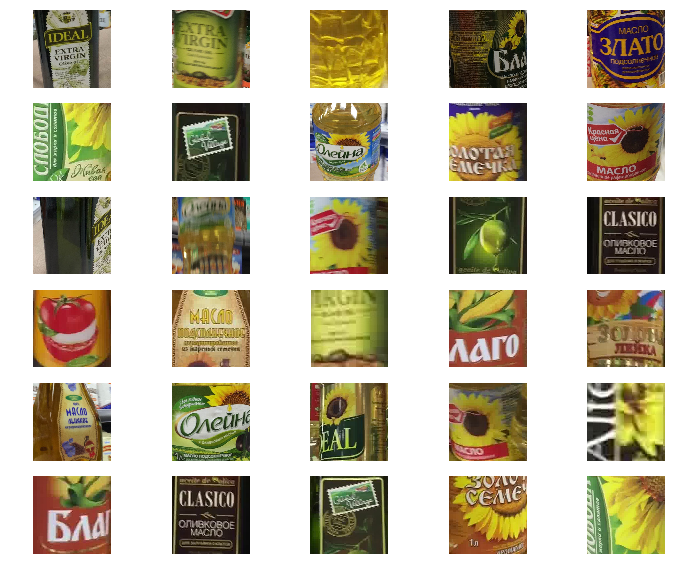

In [4]:
#checking data
import random
   
f, axarr = plt.subplots(6, 5, figsize=(12, 10))
for i in range(6):
    for j in range(5):
        index = random.randint(0, len(data))
        axarr[i, j].imshow(cv2.cvtColor(data[index], cv2.COLOR_BGR2RGB))
        axarr[i, j].axis("off")
f.subplots_adjust(hspace=.2)

In [5]:
#preprocessing
featured_data = []
for img in data:
    featured_data.append(resize(apply_grayscale(img), 32, 32))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(featured_data, labels, test_size=0.2, random_state=42)

In [6]:
#train with example network
#convolution

def conv(x, shape, strides, padding, pool_ksize, pool_strides, pool_padding, mu, sigma, dropout):
    conv1_w = tf.Variable(tf.truncated_normal(shape=shape, mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(shape[3]))
    conv1_strides = strides
    conv1_padding = padding
    conv1 = tf.nn.conv2d(x, conv1_w, conv1_strides, conv1_padding) + conv1_b
    print(conv1.get_shape())

    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, dropout)

    conv1 = tf.nn.max_pool(conv1, ksize = pool_ksize, strides = pool_strides, padding = pool_padding)
    print(conv1.get_shape())
    return conv1
    
def fc(x, shape, mu, sigma, dropout):
    fc1_w = tf.Variable(tf.truncated_normal(shape=shape, mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(shape[1]))
    fc1 = tf.add(tf.matmul(x, fc1_w), fc1_b)
    
    #Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    return fc1

In [31]:
#train with example network
#convolution
from tensorflow.contrib.layers import flatten

def MyNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    dropout = 0.75

    #conv0 = conv(x, (1, 1, 1, 3), [1, 1, 1, 1], 'VALID', [1, 1, 1, 1], [1, 1, 1, 1], 'VALID', mu, sigma, dropout)
    #input = 32x32x1. Output = 30x30x8, Pooling output = 15x15x8
    conv1 = conv(x, (3, 3, 1, 16), [1, 1, 1, 1], 'VALID', [1, 2, 2, 1], [1, 2, 2, 1], 'VALID', mu, sigma, dropout)
    #input = 15x15x8. Output = 13x13x16, Pooling output = 6x6x16
    conv2 = conv(conv1, (3, 3, 16, 32), [1, 1, 1, 1], 'VALID', [1, 2, 2, 1], [1, 2, 2, 1], 'VALID', mu, sigma, dropout)
    #input = 6x6x16. Output = 4x4x32, Pooling output = 2x2x32
    conv3 = conv(conv2, (3, 3, 32, 64), [1, 1, 1, 1], 'VALID', [1, 2, 2, 1], [1, 2, 2, 1], 'VALID', mu, sigma, dropout)
    #input = 2x2x64. Output = 1x1x128, Pooling output = 1x1x128
    conv4 = conv(conv3, (2, 2, 64, 128), [1, 1, 1, 1], 'VALID', [1, 1, 1, 1], [1, 1, 1, 1], 'VALID', mu, sigma, dropout)
    
    out_conv1 = tf.contrib.layers.flatten(conv3)
    out_conv2 = tf.contrib.layers.flatten(conv4)
    out = tf.concat([out_conv1, out_conv2], 1) #this could be removed, we may not neccesarily need placement information
    fc1 = fc(out, (384, 384), mu, sigma, dropout)

    fc_final_w = tf.Variable(tf.truncated_normal(shape=(384, 30), mean=mu, stddev=sigma))
    fc_final_b = tf.Variable(tf.zeros(30))
    fc_final = tf.add(tf.matmul(fc1, fc_final_w), fc_final_b)
    logits = fc_final
    return logits

In [32]:
#train with example network
EPOCHS = 50
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 30)

learning_rate = 0.001

logits = MyNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

(?, 30, 30, 16)
(?, 15, 15, 16)
(?, 13, 13, 32)
(?, 6, 6, 32)
(?, 4, 4, 64)
(?, 2, 2, 64)
(?, 1, 1, 128)
(?, 1, 1, 128)


In [33]:
#train with example network
with tf.Session() as sess:
    results = []
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './classifier')
    print("Model saved")

Training...

EPOCH 1 ...
Accuracy = 0.054

EPOCH 2 ...
Accuracy = 0.062

EPOCH 3 ...
Accuracy = 0.073

EPOCH 4 ...
Accuracy = 0.082

EPOCH 5 ...
Accuracy = 0.089

EPOCH 6 ...
Accuracy = 0.086

EPOCH 7 ...
Accuracy = 0.103

EPOCH 8 ...
Accuracy = 0.120

EPOCH 9 ...
Accuracy = 0.124

EPOCH 10 ...
Accuracy = 0.133

EPOCH 11 ...
Accuracy = 0.165

EPOCH 12 ...
Accuracy = 0.205

EPOCH 13 ...
Accuracy = 0.229

EPOCH 14 ...
Accuracy = 0.272

EPOCH 15 ...
Accuracy = 0.291

EPOCH 16 ...
Accuracy = 0.332

EPOCH 17 ...
Accuracy = 0.359

EPOCH 18 ...
Accuracy = 0.384

EPOCH 19 ...
Accuracy = 0.402

EPOCH 20 ...
Accuracy = 0.448

EPOCH 21 ...
Accuracy = 0.475

EPOCH 22 ...
Accuracy = 0.497

EPOCH 23 ...
Accuracy = 0.502

EPOCH 24 ...
Accuracy = 0.526

EPOCH 25 ...
Accuracy = 0.563

EPOCH 26 ...
Accuracy = 0.580

EPOCH 27 ...
Accuracy = 0.591

EPOCH 28 ...
Accuracy = 0.613

EPOCH 29 ...
Accuracy = 0.636

EPOCH 30 ...
Accuracy = 0.640

EPOCH 31 ...
Accuracy = 0.657

EPOCH 32 ...
Accuracy = 0.672

EPOC

In [34]:
#check network accuracy
with tf.Session() as sess:
    saver.restore(sess, "./classifier")

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./classifier
Test Accuracy = 0.775
